#Importing Colab and necessary packages

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install torchtext -qq
!pip install transformers evaluate wandb datasets accelerate -U -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


In [3]:
import random
import numpy as np
import joblib
from collections import Counter
from pathlib import Path
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import base64
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from functools import partial
import wandb
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline

##Path and defining folders

In [4]:
basepath = ("/content/drive/MyDrive/Applied_NLP/")
sys.path.append("/content/drive/MyDrive/Applied_NLP/Custom_Files/")
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/tmp/tmpni3wdznh',
 '/content/drive/MyDrive/Applied_NLP/Custom_Files/']

In [5]:
basefolder = Path(basepath)
datafolder = basefolder/"Class_7/Home_Work_5/Data/"
modelfolder = basefolder/"Class_8/Home_Work_6/Model_Checkpoint/"
customfolder = basefolder/"Custom_Files/"

In [6]:
from CustomPreprocessorSpacy import SpacyPreprocessor

In [7]:
datafolder

PosixPath('/content/drive/MyDrive/Applied_NLP/Class_7/Home_Work_5/Data')

In [8]:
from datasets import load_dataset

#Importing Data

In [9]:
df_train = pd.read_csv(datafolder/"emoticons_train.csv")

In [10]:
df_test = pd.read_csv(datafolder/"emoticons_test.csv")

##Labels in the data

In [11]:
labels = [label for label in df_train.columns if label not in ["Tweet","ID"]]
id2labels = {idx:label for idx, label in enumerate(labels)}
labels2id = {v:k for k,v in id2labels.items()}
labels2id

{'anger': 0,
 'anticipation': 1,
 'disgust': 2,
 'fear': 3,
 'joy': 4,
 'love': 5,
 'optimism': 6,
 'pessimism': 7,
 'sadness': 8,
 'surprise': 9,
 'trust': 10}

#EDA of the classes

In [12]:
def dist_class(df):
    df = df.iloc[:,2:]
    ones_count = df.sum()
    zeroes_count = (df == 0).sum()
    plt.figure(figsize=(15, 9))
    ones_count.plot(kind='bar', color='blue', position=0.5, width=0.4, label='Ones')
    zeroes_count.plot(kind='bar', color='orange', position=-0.5, width=0.4, label='Zeros')
    plt.title('Counts of Ones and Zeros for Each Class')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend()
    plt.show()

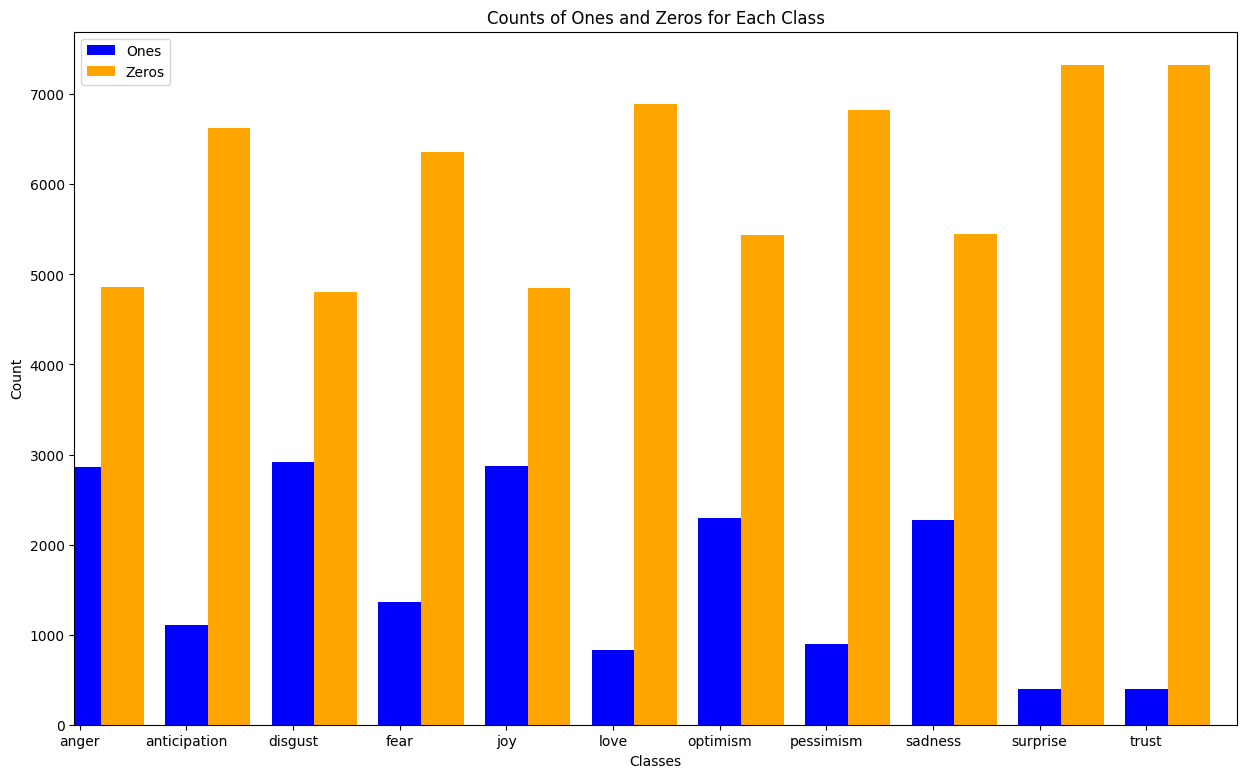

In [13]:
dist_class(df_train)

## EDA for each class

In [14]:
def frequency(x):
  freq = df_train[x].value_counts(ascending=True)
  fig = freq.plot.barh()
  fig.set_ylabel('class frequency')
  fig.set_xlabel(x)
  plt.show()

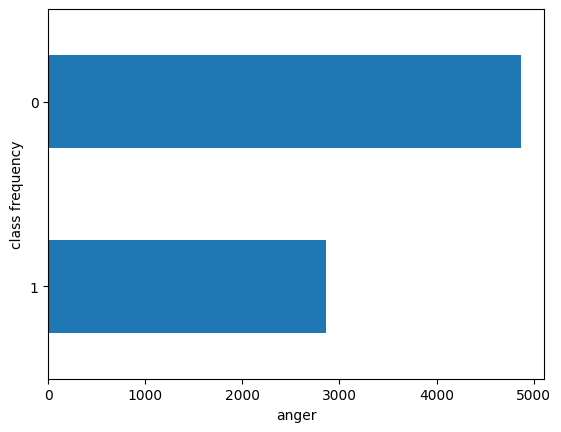

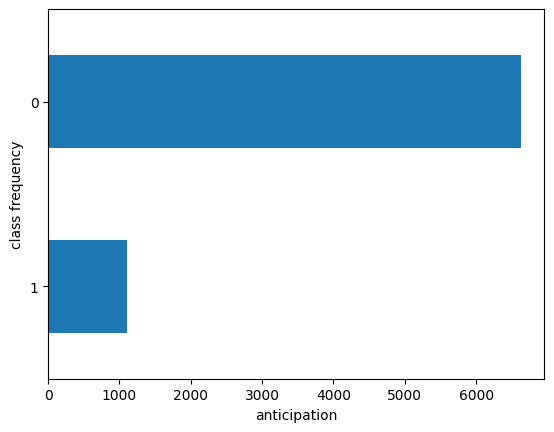

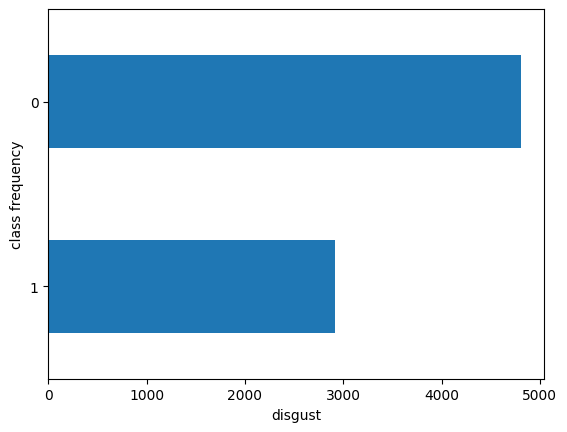

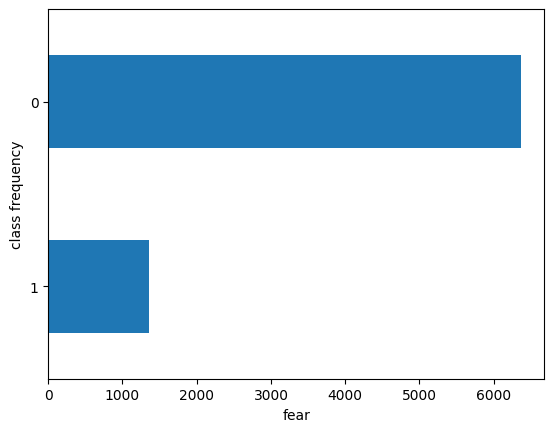

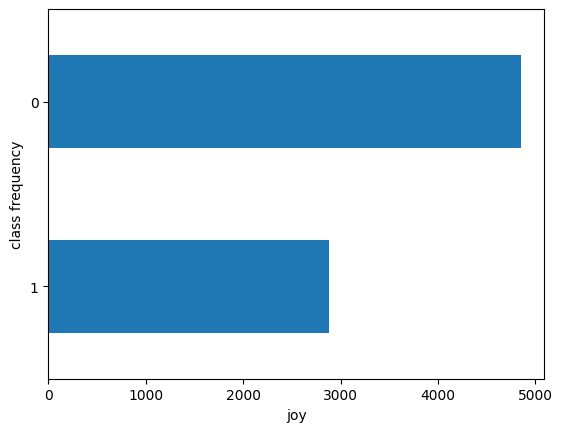

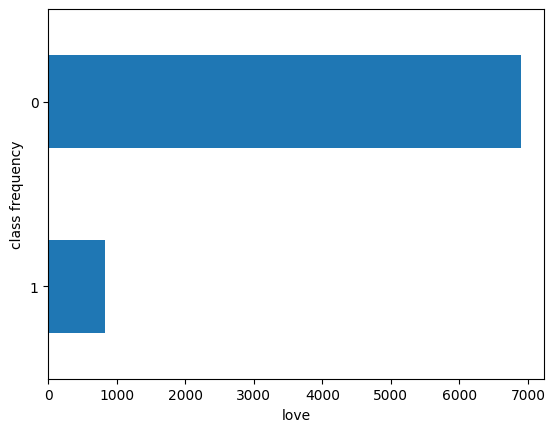

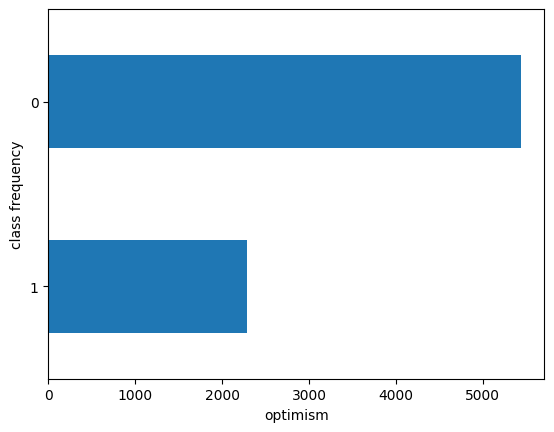

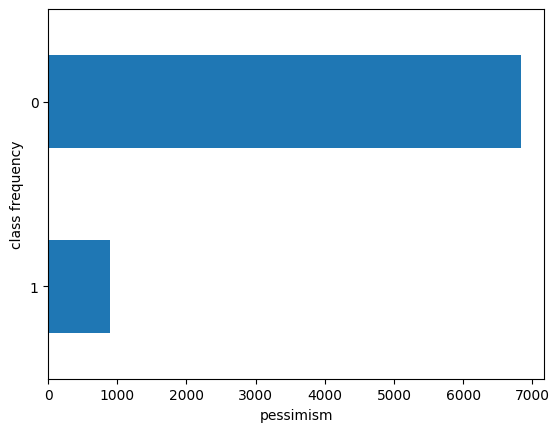

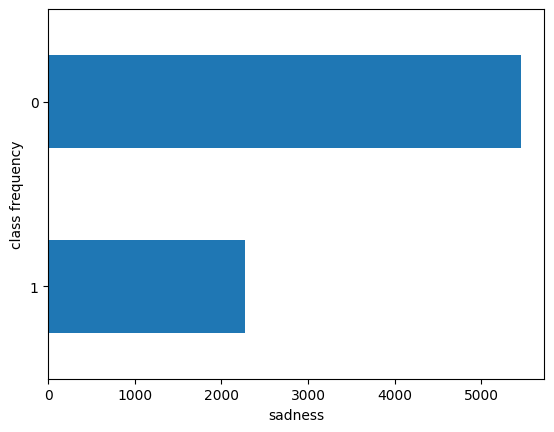

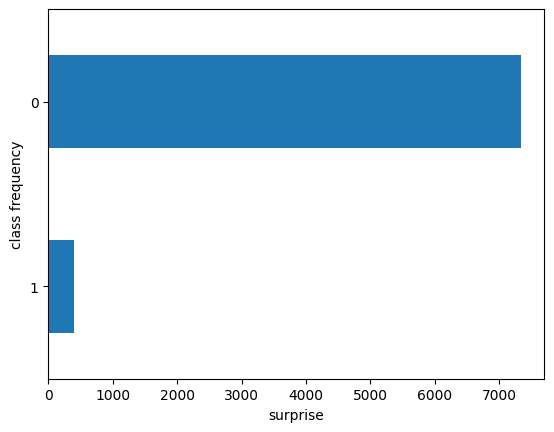

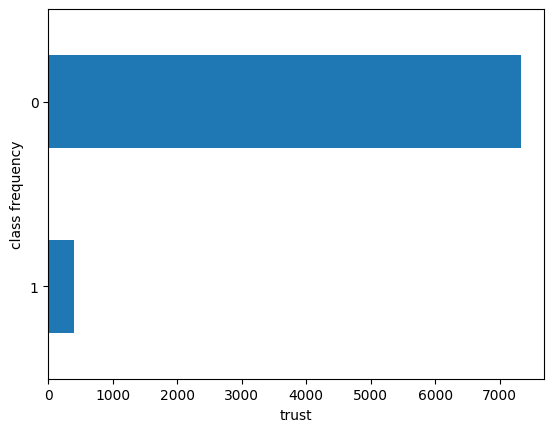

In [15]:
for x in labels:
  frequency(x)

#Dropping,Preprocessing and Splitting

In [16]:
df_train.drop("ID",axis=1,inplace=True)
df_test.drop("ID", axis=1, inplace=True)

##Spacy Preprocessing

In [17]:
sp = SpacyPreprocessor(model='en_core_web_sm', batch_size=64, lemmatize=True, lower=True,
                                    remove_stop=True, remove_punct=True, remove_email=True,
                                    remove_url=True, remove_num=False, stemming=False,
                                    add_user_mention_prefix=False, remove_hashtag_prefix=True, basic_clean_only=False)

In [18]:
X_train_total = df_train["Tweet"].tolist()
X_test = df_test["Tweet"].tolist()

In [19]:
y_test = df_train

In [20]:
y_train_total = df_train.drop("Tweet",axis=1).to_numpy().astype(float)
y_test = df_test.drop("Tweet",axis=1).to_numpy()

In [21]:
y_train_total

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y_test = np.where(y_test == "NONE",0,y_test).astype(float)

##Train-Valid Split

In [23]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train_total,y_train_total,test_size=0.3, random_state=42, shuffle=True)

##Spacy preprocessor

In [25]:
X_train_preprocessed = sp.fit_transform(X_train)
X_valid_preprocessed = sp.transform(X_valid)
X_test_preprocessed = sp.transform(X_test)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


##Data Dictionaries

In [26]:
trainset = Dataset.from_dict({
    'texts': X_train_preprocessed,
    'labels': y_train
})

validset = Dataset.from_dict({
    'texts': X_valid_preprocessed,
    'labels': y_valid
})

testset = Dataset.from_dict({
    'texts': X_test_preprocessed,
    'labels': y_test
})

In [27]:
trainset[0:5]

{'texts': ['@kmunie7 @karanesch helluva lot animated actual game >.<',
  "despite sharing o'neill article sadden gazza case fury sentence remark",
  '@mtailor 20 well tailor tailor know #navy vs. #blue $ 500 4 week #innacurate suit',
  'earth projection good happy true soul poisonous fucking snake #patronus #adder #offende',
  'patti sad stamp run sofa plenty love affection usual'],
 'labels': [[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]]}

In [28]:
testset[0:5]

{'texts': ['@adnan__786 @asyounotwish not worry indian army way dispatch terrorists hell',
  'academy sciences eschew normally sober tone scientific paper call massive loss wildlife biological annihilation',
  'blow opportunity #mad',
  'time 2 week 30 😥',
  '#deppression real partner w/ #depresse people truly not understand depth affect add #anxiety make bad'],
 'labels': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [29]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

#Distil-bert as Checkpoint

In [30]:
checkpoint_distilroberta = "distilroberta-base"
tokenizer_distilroberta = AutoTokenizer.from_pretrained(checkpoint_distilroberta)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

##Tokenize for distil-bert



In [31]:
def tokenize_fn_roberta(batch):
  return tokenizer_distilroberta(text = batch["texts"], truncation=True, padding="max_length",return_tensors = "pt", max_length = 128)

In [32]:
tokenized_dataset_train_roberta = trainset.map(tokenize_fn_roberta,batched=True)
tokenized_dataset_valid_roberta = validset.map(tokenize_fn_roberta,batched=True)
tokenized_dataset_test_roberta = testset.map(tokenize_fn_roberta,batched=True)

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/2318 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [33]:
tokenized_dataset_train_roberta

Dataset({
    features: ['texts', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 5406
})

In [34]:
tokenized_dataset_train_roberta = tokenized_dataset_train_roberta.remove_columns(["texts"])
tokenized_dataset_valid_roberta = tokenized_dataset_valid_roberta.remove_columns(["texts"])
tokenized_dataset_test_roberta = tokenized_dataset_test_roberta.remove_columns(["texts"])

In [35]:
tokenized_dataset_train_roberta

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5406
})

In [36]:
tokenized_dataset_train_roberta.set_format(type='torch')
tokenized_dataset_valid_roberta.set_format(type='torch')
tokenized_dataset_test_roberta.set_format(type='torch')

In [37]:
tokenized_dataset_train_roberta

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5406
})

In [38]:
tokenized_dataset_test_roberta

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 3259
})

##Model for distil-bert

In [39]:
model_distil_roberta = AutoModelForSequenceClassification.from_pretrained(checkpoint_distilroberta,num_labels = 11,problem_type="multi_label_classification",id2label=id2labels,label2id=labels2id)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
import evaluate
from transformers import EvalPrediction
import torch
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

##Metrics labelling functions

In [41]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,'Accuracy': accuracy}
    return metrics

def compute_metrics_1(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,tuple) else p.predictions
    result = multi_label_metrics(predictions=preds,labels=p.label_ids)
    return result

##Training Args

In [42]:
training_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    learning_rate=0.000015,
    optim='adamw_torch',
    remove_unused_columns=False,
    output_dir=str(modelfolder),
    evaluation_strategy='steps',
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_strategy='steps',
    logging_steps=10,
    report_to='wandb',
    run_name='emoticon-distilroberta-1',
)

##Bert Trainer

In [43]:
trainer_distil_roberta = Trainer(
    model=model_distil_roberta,
    args=training_args,
    train_dataset = tokenized_dataset_train_roberta,
    eval_dataset = tokenized_dataset_valid_roberta,
    compute_metrics=compute_metrics_1,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [44]:
!wandb login 5b0f2851a77f589c556f16598a0b181257a541e9

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [45]:
%env WANDB_PROJECT = nlp_course_spring_2024-emtoicons-analysis-hf-trainer

env: WANDB_PROJECT=nlp_course_spring_2024-emtoicons-analysis-hf-trainer


##Training

In [46]:
trainer_distil_roberta.train()

wandb: Currently logged in as: abhishekmoguluri (abhishek-moguluri). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1,Accuracy
100,0.454600,0.469176,0.000000,0.023727
200,0.418700,0.423584,0.442732,0.124245
300,0.409700,0.410927,0.502594,0.163934
400,0.403000,0.396640,0.501838,0.165229
500,0.351500,0.389934,0.541839,0.186368
600,0.415900,0.377381,0.540614,0.180328
700,0.370800,0.371887,0.575135,0.188525
800,0.372900,0.371391,0.594523,0.198878
900,0.344600,0.362864,0.593037,0.208801
1000,0.338100,0.364096,0.598584,0.202330


TrainOutput(global_step=3380, training_loss=0.33049390788614397, metrics={'train_runtime': 773.6784, 'train_samples_per_second': 34.937, 'train_steps_per_second': 4.369, 'total_flos': 895292119733760.0, 'train_loss': 0.33049390788614397, 'epoch': 5.0})

##Evaluation on validation data set

In [47]:
trainer_distil_roberta.evaluate()

{'eval_loss': 0.34477412700653076,
 'eval_f1': 0.6377312461882496,
 'eval_Accuracy': 0.2385677308024159,
 'eval_runtime': 8.0481,
 'eval_samples_per_second': 288.017,
 'eval_steps_per_second': 36.033,
 'epoch': 5.0}

In [48]:
valid_output_roberta = trainer_distil_roberta.predict(tokenized_dataset_train_roberta)

In [49]:
valid_output_roberta._fields

('predictions', 'label_ids', 'metrics')

In [50]:
valid_output_roberta[0]

array([[-2.8749454 , -1.0799594 , -2.8496375 , ..., -3.2919648 ,
        -2.1648757 , -2.6424098 ],
       [ 2.595303  , -3.0499468 ,  2.6079733 , ...,  0.3934707 ,
        -3.2783418 , -4.5386105 ],
       [-0.6744969 , -0.4647354 , -0.53128874, ..., -2.2102318 ,
        -2.053262  , -3.0368795 ],
       ...,
       [ 2.396876  , -2.8023283 ,  1.9005203 , ..., -1.6727105 ,
        -3.236118  , -4.136453  ],
       [-3.455772  , -2.2244384 , -3.3496718 , ..., -2.8325422 ,
        -2.6368504 , -2.4286377 ],
       [-3.979003  , -2.3775277 , -3.743573  , ..., -1.9923245 ,
        -3.4365344 , -2.221049  ]], dtype=float32)

In [51]:
best_model_roberta_checkpoint_step = trainer_distil_roberta.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_roberta_checkpoint_step}.")

The best model was saved at step 3000.


In [52]:
wandb.finish()

eval/Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇██████████████████████
eval/f1,▁▆▇▇▇▇▇███████████████████████████
eval/loss,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▂▃▄▅▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
eval/samples_per_second,█▇▆▄▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂
eval/steps_per_second,█▇▆▄▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▁▁▃▃▄▂▃▃▂▆▄▅▃▄▅▅▄▄▃▃▄▆▅▄▃▂▅▄▃▃▂▃▄▅▅█▄▅▂▄
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▆▅▆▅▄▆▄▄▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▁▂▁▁▂▂▃▁▂▂▂


##Save the model

In [55]:
model_roberta_checkpoint = str(modelfolder/f'checkpoint-{best_model_roberta_checkpoint_step}')
model_roberta_checkpoint

'/content/drive/MyDrive/Applied_NLP/Class_8/Home_Work_6/Model_Checkpoint/checkpoint-3000'

In [57]:
model_distil_roberta = AutoModelForSequenceClassification.from_pretrained(model_roberta_checkpoint)

##Validation set

In [58]:
training_args_roberta_test = TrainingArguments(
    output_dir=str(modelfolder),
    per_device_eval_batch_size=8,
    do_train=False,
    do_eval=True,
    report_to='wandb',
    run_name='emoticon_hf_trainer',
)

In [59]:
tokenized_dataset_valid_roberta

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 2318
})

In [60]:
tokenized_dataset_test_roberta["labels"][:5]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [61]:
trainer_roberta_test = Trainer(
    model=model_distil_roberta,
    args=training_args_roberta_test,
    eval_dataset=tokenized_dataset_test_roberta,
    compute_metrics=compute_metrics_1,)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [62]:
roberta_test_results = trainer_roberta_test.evaluate()

In [63]:
roberta_test_results

{'eval_loss': 0.45345228910446167,
 'eval_f1': 0.0,
 'eval_Accuracy': 0.0346732126419147,
 'eval_runtime': 11.2594,
 'eval_samples_per_second': 289.447,
 'eval_steps_per_second': 36.236}

In [64]:
wandb.log({"test_accuracy": roberta_test_results["eval_Accuracy"], "test_loss": roberta_test_results["eval_loss"], "test_f1": roberta_test_results["eval_f1"]})

In [65]:
roberta_test_output = trainer_distil_roberta.predict(tokenized_dataset_test_roberta)
roberta_test_output

PredictionOutput(predictions=array([[ 0.8592023 , -2.624855  ,  1.2500526 , ..., -1.3617513 ,
        -3.3073103 , -4.173488  ],
       [-0.33788928, -2.4582963 ,  0.2704007 , ..., -0.13081346,
        -3.5141864 , -4.173585  ],
       [ 2.6919355 , -3.4514704 ,  2.1658413 , ..., -0.83744144,
        -3.4168675 , -4.4834456 ],
       ...,
       [ 3.2267878 , -2.9034603 ,  2.5351768 , ..., -1.7139211 ,
        -2.9119837 , -3.868168  ],
       [-3.068839  , -2.241294  , -3.26456   , ..., -3.3346424 ,
        -2.5110726 , -1.6806593 ],
       [ 2.4178805 , -2.6046016 ,  1.833351  , ..., -1.0230232 ,
        -2.7808945 , -4.21462   ]], dtype=float32), label_ids=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), metrics={'test_loss': 0.45345228910446167, 'test_f1': 0.0, 'test_Accuracy':

In [66]:
roberta_test_preds = roberta_test_output.predictions

In [67]:
roberta_test_preds = torch.tensor(roberta_test_preds)

##Predictions to Probablities

In [68]:
def coversion(predictions, threshold=0.25):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    results = np.zeros(probs.shape)
    results[np.where(probs >= threshold)] = 1
    return results

In [69]:
roberta_test_preds_final = coversion(roberta_test_preds)
roberta_test_preds_final

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

In [70]:
df_test = pd.read_csv(datafolder/"emoticons_test.csv")

In [71]:
df_test.columns

Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [72]:
df_test[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']] = roberta_test_preds_final

In [73]:
df_test.drop(["Tweet"],axis =1, inplace = True)

In [74]:
df_test.to_csv(basefolder/"Class_8/Home_Work_6/Submissions/roberta-test-1.csv")

##Inference

In [75]:
mapped_labels =[]
for prediction_row in roberta_test_preds_final:
    mapped_row = [label for label, pred in zip(labels, prediction_row) if pred]
    mapped_labels.append(mapped_row)

In [76]:
from pprint import pprint
pprint(mapped_labels[:10])

[['anger', 'disgust', 'fear'],
 ['anger', 'disgust', 'fear', 'sadness'],
 ['anger', 'disgust', 'sadness'],
 ['anger', 'disgust', 'sadness'],
 ['fear', 'pessimism', 'sadness'],
 ['anger', 'disgust', 'fear'],
 ['anticipation', 'joy'],
 ['joy', 'love', 'optimism'],
 ['joy', 'love', 'optimism'],
 ['disgust', 'fear', 'pessimism', 'sadness']]
